In [ ]:
import sys
!{sys.executable} -m pip install altair
!{sys.executable} -m pip install altair_data_server
!{sys.executable} -m pip install prince
!{sys.executable} -m pip install kmodes
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install scikeras

import pandas as pd
import numpy as np
import altair as alt
import prince

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

%matplotlib inline
alt.data_transformers.enable('data_server')

In [2]:
default_df = pd.read_excel('assets/default of credit card clients.xls', header=1, index_col=0)
default_df.rename(columns={'default payment next month': 'default', 'PAY_0': 'PAY_1'}, inplace=True)
default_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [75]:
default_df.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default'],
      dtype='object')

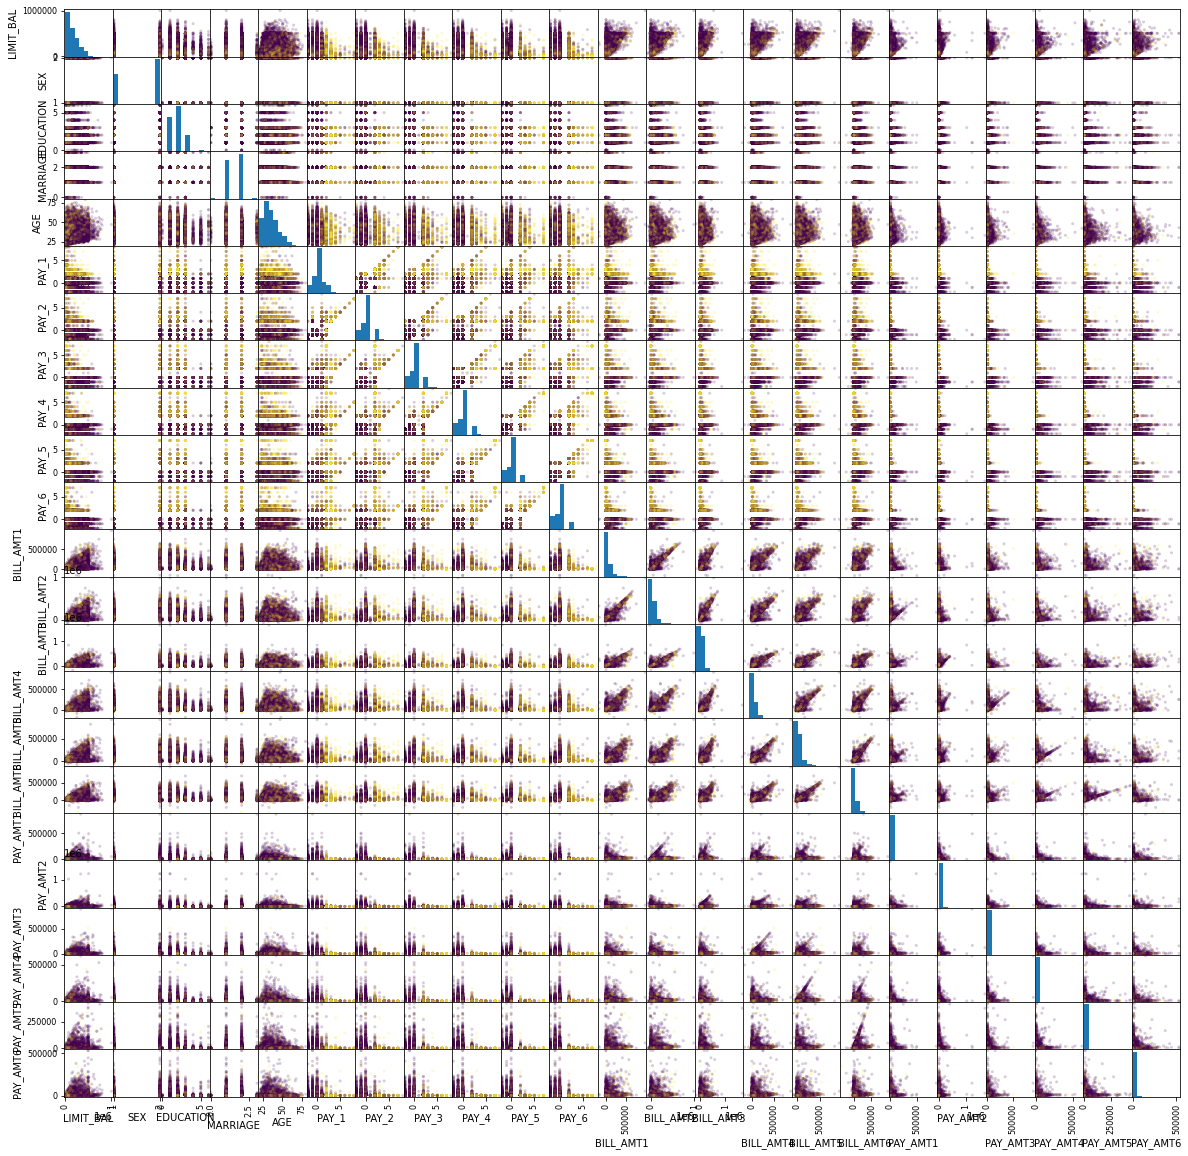

In [112]:
X_def_df = default_df.drop('default', axis=1)
y_def_df = default_df['default']

scatter_matrix(X_def_df, c=y_def_df, alpha = 0.2, figsize=[20,20]);

### One hot encoding of categorical and Scaling of continuous features (PCA)

In [220]:
encode_cols = [
       'SEX', 'EDUCATION', 'MARRIAGE', 
       'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
scale_cols = [
       'LIMIT_BAL', 'AGE',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
       'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [221]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

encoded_res = ohe.fit_transform(default_df[encode_cols])
scaled_res = scaler.fit_transform(default_df[scale_cols]) 

processed_df = np.concatenate([encoded_res,scaled_res], axis=1)

[0.31882139 0.10497336]


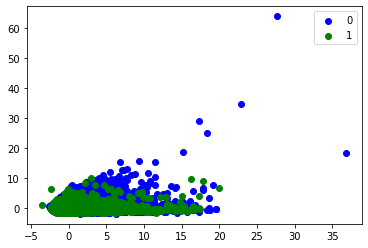

In [275]:
X = processed_df
y = default_df['default']

pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)
X_r = pca.transform(X)

colors = ['blue','green']

for target, color in enumerate(colors):
    plt.scatter(X_r[y==target,0], X_r[y==target,1], label=target, color=color)

plt.legend()

#### [Mean of bill/payment] One hot encoding of categorical, Scaling of continuous (PCA)

In [290]:
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False)

mean_scale_cols = [
    'LIMIT_BAL', 'AGE', 
    'mean_bill', 'mean_pay'
]

mean_mixed_data_df = default_df.copy()

bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

mean_mixed_data_df['mean_bill'] = mean_mixed_data_df[bill_cols].mean(axis=1)
mean_mixed_data_df = mean_mixed_data_df.drop(bill_cols,axis=1)

mean_mixed_data_df['mean_pay'] = mean_mixed_data_df[pay_cols].mean(axis=1)
mean_mixed_data_df = mean_mixed_data_df.drop(pay_cols,axis=1)

scaled_res = scaler.fit_transform(mean_mixed_data_df[mean_scale_cols]) 
encoded_res = ohe.fit_transform(mean_mixed_data_df[encode_cols])

processed_df = np.concatenate([encoded_res,scaled_res], axis=1)

[0.19908006 0.17350476]


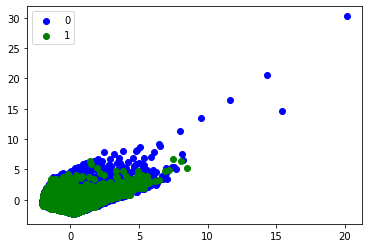

In [291]:
X = processed_df
y = mean_mixed_data_df['default']

pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)
X_r = pca.transform(X)

colors = ['blue','green']

for target, color in enumerate(colors):
    plt.scatter(X_r[y==target,0], X_r[y==target,1], label=target, color=color)

plt.legend()

Trying various sets of continuous variables.

In [295]:
scale_cols = [
       # 'LIMIT_BAL', 'AGE', 
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

[0.84870179 0.04871288]


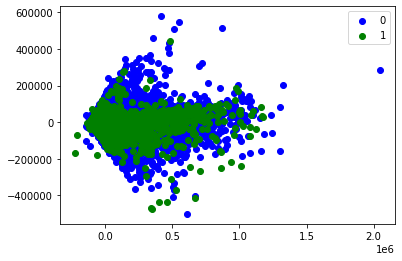

In [296]:
continuous_df = default_df[scale_cols]
X = continuous_df
y = default_df['default']

pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)
X_r = pca.transform(X)

colors = ['blue','green']

for target, color in enumerate(colors):
    plt.scatter(X_r[y==target,0], X_r[y==target,1], label=target, color=color)

plt.legend()

### Categorical-Continuous variable dim reduction (FAMD)

In [251]:
encode_cols = [
       'SEX', 'EDUCATION', 'MARRIAGE', 
       'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
scale_cols = [
       'LIMIT_BAL', 'AGE', 
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

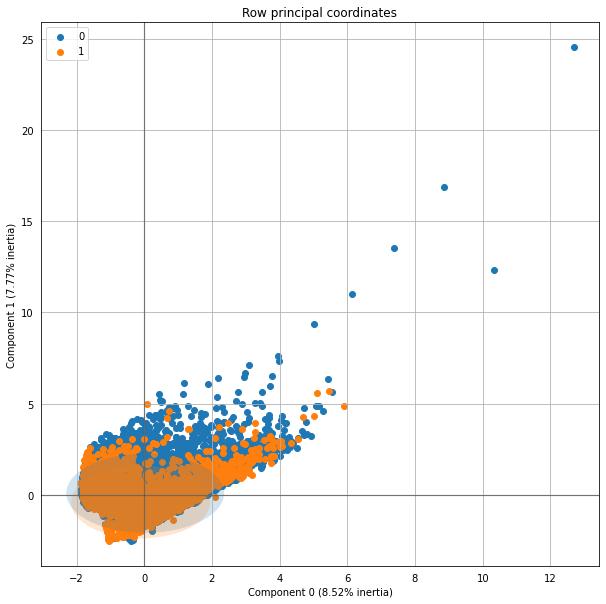

In [252]:
# mixed_data_df = default_df.copy()
mixed_data_df[encode_cols] = mixed_data_df[encode_cols].astype(str)

famd = prince.FAMD(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
    )

famd = famd.fit(mixed_data_df.drop(['default'], axis='columns'))

ax = famd.plot_row_coordinates(
     mixed_data_df,
     ax=None,
     figsize=(10, 10),
     x_component=0,
     y_component=1,
     labels=None,
     color_labels=mixed_data_df['default'],
     ellipse_outline=False,
     ellipse_fill=True,
    show_points=True
)

#### Standardized continuous variables

In [256]:
mean_scale_cols = [
    'LIMIT_BAL', 'AGE', 'mean_bill', 'mean_pay'
]

ct = ColumnTransformer([
        ('standardize', StandardScaler(), mean_scale_cols)
    ])


std_mixed_data_df = default_df.copy()

bill_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
pay_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

std_mixed_data_df['mean_bill'] = std_mixed_data_df[bill_cols].mean(axis=1)
std_mixed_data_df = std_mixed_data_df.drop(bill_cols,axis=1)

std_mixed_data_df['mean_pay'] = std_mixed_data_df[pay_cols].mean(axis=1)
std_mixed_data_df = std_mixed_data_df.drop(pay_cols,axis=1)


std_mixed_data_df[mean_scale_cols] = ct.fit_transform(std_mixed_data_df[mean_scale_cols])

In [257]:
std_mixed_data_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default,mean_bill,mean_pay
ID,,,,,,,,,,,,,,
1,-1.136720,2,2,1,-1.246020,2,2,-1,-1,-2,-2,1,-0.690692,-0.509027
2,-0.365981,2,2,2,-1.029047,-1,2,0,0,0,2,1,-0.665997,-0.438153
3,-0.597202,2,2,2,-0.161156,0,0,0,0,0,0,0,-0.443170,-0.339216
4,-0.905498,2,2,1,0.164303,0,0,0,0,0,0,0,-0.101507,-0.382454
5,-0.905498,1,2,1,2.334029,-1,0,-1,0,0,0,0,-0.422920,0.450421


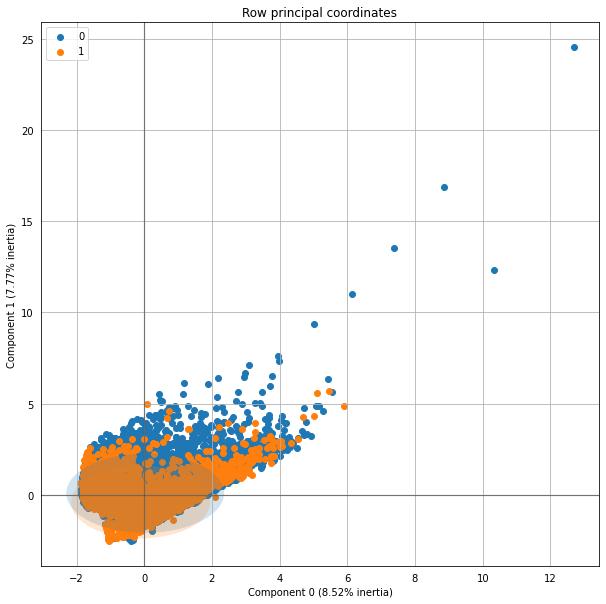

In [258]:
# mixed_data_df = default_df.copy()
std_mixed_data_df[encode_cols] = std_mixed_data_df[encode_cols].astype(str)

famd = prince.FAMD(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
    )

famd = famd.fit(std_mixed_data_df.drop(['default'], axis='columns'))

ax = famd.plot_row_coordinates(
     std_mixed_data_df,
     ax=None,
     figsize=(10, 10),
     x_component=0,
     y_component=1,
     labels=None,
     color_labels=std_mixed_data_df['default'],
     ellipse_outline=False,
     ellipse_fill=True,
    show_points=True
)

## Dimensionality reduction experiment

Experimenting with the **prince** package here to attempt dimensionality reduction on data containing a mix of numeric/continuous and categorical variables (https://github.com/MaxHalford/prince#factor-analysis-of-mixed-data-famd).
Differences are noticeable, but clusters are not well separated in 2-dimensional feature space.

In [69]:
# data transformation
def_cat_df = default_df.copy()
def_cat_df['AGE_GROUP'] = (def_cat_df.AGE / 10).apply(np.floor).astype(int)
def_cat_df['PAY_1_DUE'] = np.where(def_cat_df['PAY_1'] <= 0, 'YES', 'NO')
def_cat_df['PAY_2_DUE'] = np.where(def_cat_df['PAY_2'] <= 0, 'YES', 'NO')
def_cat_df['PAY_3_DUE'] = np.where(def_cat_df['PAY_3'] <= 0, 'YES', 'NO')
def_cat_df['PAY_4_DUE'] = np.where(def_cat_df['PAY_4'] <= 0, 'YES', 'NO')
def_cat_df['PAY_5_DUE'] = np.where(def_cat_df['PAY_5'] <= 0, 'YES', 'NO')
def_cat_df['PAY_6_DUE'] = np.where(def_cat_df['PAY_6'] <= 0, 'YES', 'NO')
def_cat_df = pd.get_dummies(def_cat_df, columns=['PAY_1_DUE', 'PAY_2_DUE', 'PAY_3_DUE', 'PAY_4_DUE', 'PAY_5_DUE', 'PAY_6_DUE'], drop_first=True)
def_cat_df.drop(columns=['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'AGE'], inplace=True)
def_cat_df['SEX'] = np.where(def_cat_df['SEX'] == 1, 'MALE', 'FEMALE')
def_cat_df = pd.get_dummies(def_cat_df, columns=['SEX'], drop_first=True)
def_cat_df = pd.get_dummies(def_cat_df, columns=['EDUCATION', 'MARRIAGE', 'AGE_GROUP'])
def_cat_df.head()

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,...,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,AGE_GROUP_2,AGE_GROUP_3,AGE_GROUP_4,AGE_GROUP_5,AGE_GROUP_6,AGE_GROUP_7
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,3913,3102,689,0,0,0,0,689,0,...,0,1,0,0,1,0,0,0,0,0
2,120000,2682,1725,2682,3272,3455,3261,0,1000,1000,...,0,0,1,0,1,0,0,0,0,0
3,90000,29239,14027,13559,14331,14948,15549,1518,1500,1000,...,0,0,1,0,0,1,0,0,0,0
4,50000,46990,48233,49291,28314,28959,29547,2000,2019,1200,...,0,1,0,0,0,1,0,0,0,0
5,50000,8617,5670,35835,20940,19146,19131,2000,36681,10000,...,0,1,0,0,0,0,0,1,0,0


<AxesSubplot:title={'center':'Row principal coordinates'}, xlabel='Component 0 (18.40% inertia)', ylabel='Component 1 (9.67% inertia)'>

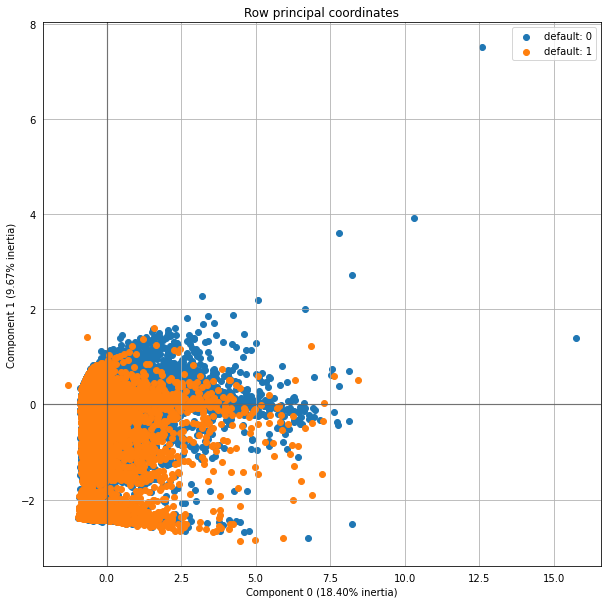

In [5]:
famd = prince.FAMD(random_state=42)
cat_cols = ['PAY_1_DUE_YES', 'PAY_2_DUE_YES', 'PAY_3_DUE_YES', 'PAY_4_DUE_YES', 'PAY_5_DUE_YES',
            'PAY_6_DUE_YES', 'SEX_MALE', 'EDUCATION_0', 'EDUCATION_1',
            'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5',
            'EDUCATION_6', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
            'AGE_GROUP_2', 'AGE_GROUP_3', 'AGE_GROUP_4', 'AGE_GROUP_5',
            'AGE_GROUP_6', 'AGE_GROUP_7']
def_cat_df[cat_cols] = def_cat_df[cat_cols].astype(str)
famd = famd.fit(def_cat_df.drop(['default'], axis=1))
famd.row_coordinates(def_cat_df)

famd.plot_row_coordinates(
    def_cat_df,
    ax=None,
    figsize=(10, 10),
    x_component=0,
    y_component=1,
    labels=None,
    color_labels=['default: {}'.format(d) for d in def_cat_df['default']],
    ellipse_outline=False,
    ellipse_fill=False,
    show_points=True
)